# Kalman Filter

Ce notebook présente l'utilisation du fichier `kalmanWoFost.py` pour assimiler des données

On commence par importer le module en question, ainsi que `numpy` pour préparer des observations fictivs et `DateTime` pour créer des dates.


In [1]:
from kalmanWoFost import KalmanWofostDA
import numpy as np 
from pcse.models import Wofost72_WLP_FD
import datetime as dt
import pandas as pd

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 179, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\noe\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\noe\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\noe\AppData\Roaming\Pyth

On créé ensuite des observations : ici, il faudra mettre les observations receuilli par le robot. Pour l'instant, le code prend en compte les données pour "LAI" et "SM"

In [2]:
# Commençons par définir les observations
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]

observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
obs_pack = [(dates_of_observation[i],observed_lai[i],observed_sm[i]) for i in range(5)]

On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

In [3]:
variables_for_DA = ["LAI", "SM"]
from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters,weather,agromanagement)
wofost.run_till_terminate()

df_reality = pd.DataFrame(wofost.get_output())
df_reality = df_reality.set_index("day")

obs = df_reality.sample(n=5).sort_index()
dates_of_observation = obs.index

observed_lai = np.array(obs['LAI'])
std_lai = 0.1*observed_lai
std_sm = 0.1*observed_sm

observed_sm = np.array(obs['SM'])
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 179, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\noe\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\noe\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\noe\AppData\Roaming\Pyth

Finalement, on peut créer et faire tourner notre modèle:

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 179, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\noe\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\noe\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\noe\AppData\Roaming\Pyth

[KalmanWoFoStDA] Assimilating data for {'LAI': (0.1850328339415831, 0.01850328339415831), 'SM': (0.26600184840406343, 0.028499999999999998)} on day 2000-01-05 
[KalmanWoFoStDA] Assimilating data for {'LAI': (5.266142421339026, 0.5266142421339026), 'SM': (0.1735627886484022, 0.026000000000000002)} on day 2000-03-29 


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 179, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\noe\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\noe\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\noe\AppData\Roaming\Pyth

[KalmanWoFoStDA] Assimilating data for {'LAI': (1.1844047219677485, 0.11844047219677485), 'SM': (0.21823383019921463, 0.028000000000000004)} on day 2000-05-08 
[KalmanWoFoStDA] Assimilating data for {'LAI': (0.05424743041564401, 0.005424743041564401), 'SM': (0.20681159391072396, 0.018)} on day 2000-05-20 
[KalmanWoFoStDA] Assimilating data for {'LAI': (0.025196281177444345, 0.0025196281177444347), 'SM': (0.20436122863947573, 0.017)} on day 2000-05-22 
[KalmanWoFostDA] 5 observations assimilated
50


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 179, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\noe\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\noe\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\noe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\noe\AppData\Roaming\Pyth

[KalmanWoFoStDA] Displaying data for 50 up to day None 


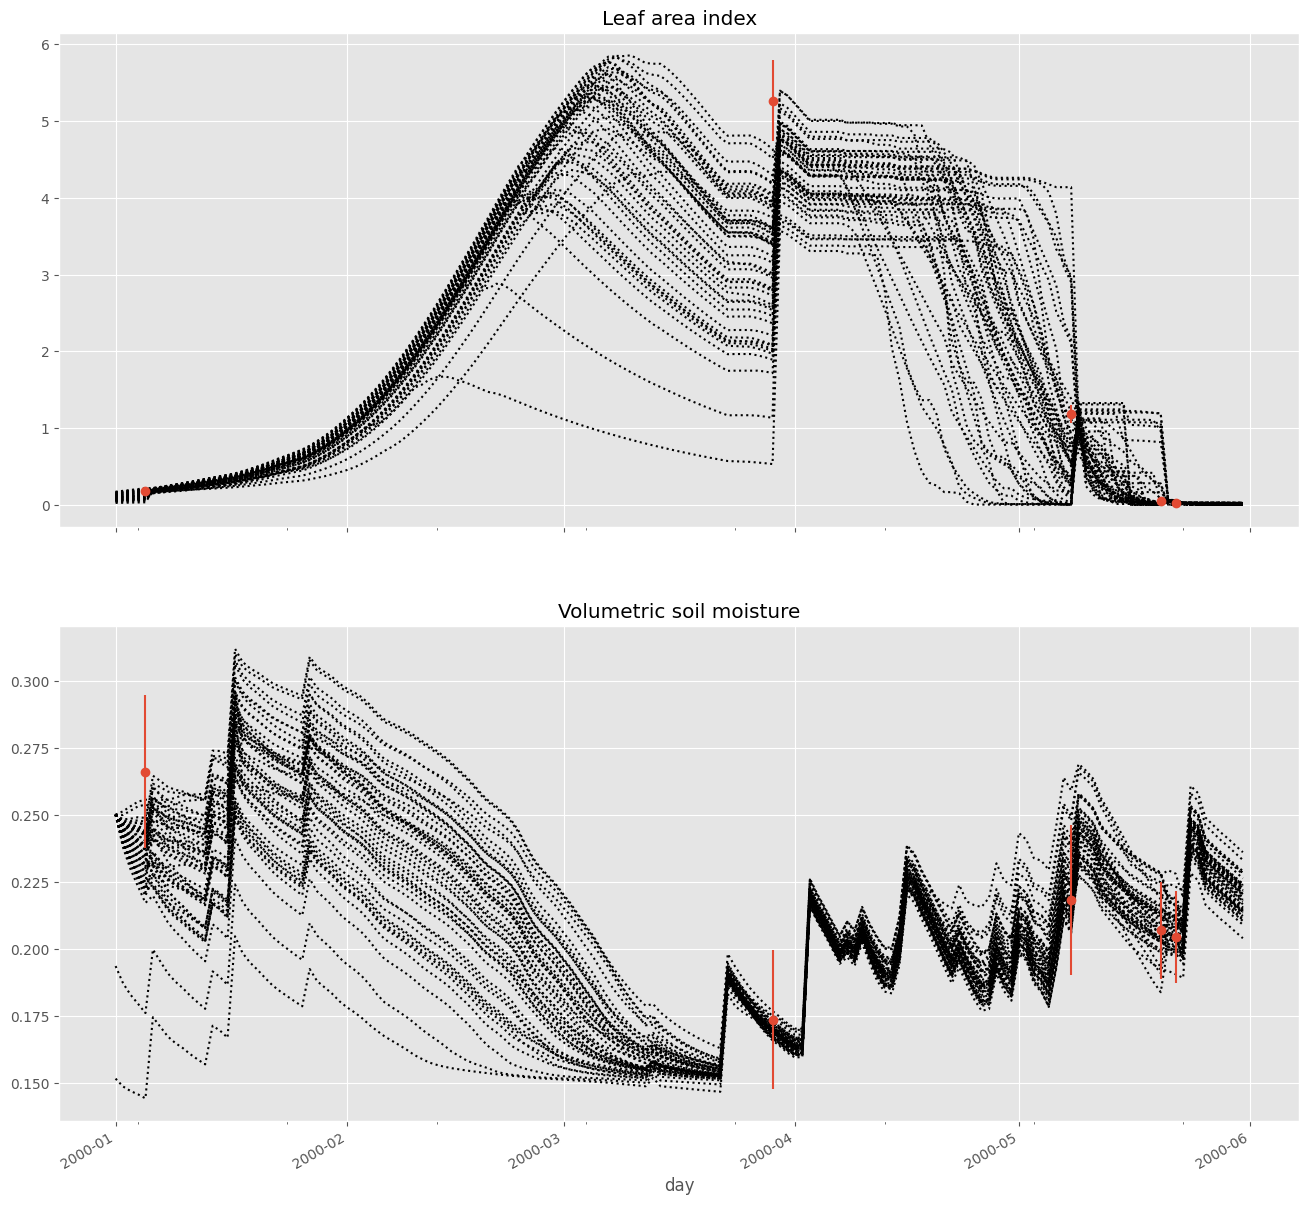

In [4]:
override_parameters = {}
# Initial conditions
ensemble_size=50
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))

kwf = KalmanWofostDA(ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
print(len(kwf.ensemble))
kwf.moveForward(20)
kwf.displayLAIsM()

On peut récupérer le résultat de notre simulation

[KalmanWoFoStDA] Displaying data for 50 up to day None 


<AxesSubplot: title={'center': 'Volumetric soil moisture'}, xlabel='day'>

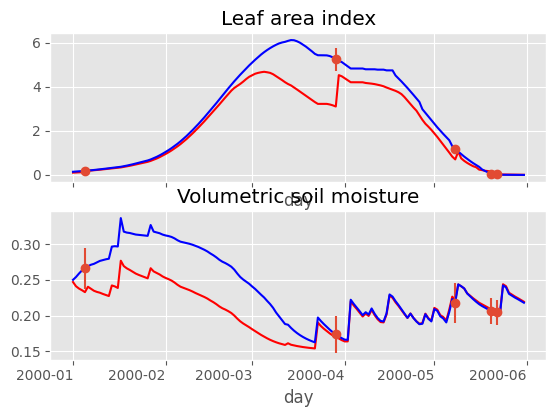

In [5]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
kwf.displayLAIsM(average=True,fig=fig,axes=ax)
df_reality['LAI'].plot(style='b-', ax = ax[0])
df_reality['SM'].plot(style='b-',ax = ax[1])